In [1]:
# 📦 Install all required libraries (Jupyter notebook compatible)
!pip install -q pandas numpy scikit-learn seaborn matplotlib tqdm pillow torch torchvision transformers xgboost joblib
!pip install emoji

# ✅ Import libraries
import os
import joblib
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
 # or use tqdm if you're not in Jupyter

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from transformers import BertTokenizer, BertModel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

# 🚀 Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on: cuda


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Drop if username or followers/follows are missing
train_df = train_df.dropna(subset=['username', 'followersCount', 'followsCount']).reset_index(drop=True)
test_df = test_df.dropna(subset=['username', 'followersCount', 'followsCount']).reset_index(drop=True)

# Fill missing follower/follow counts
for df in [train_df, test_df]:
    df['followersCount'] = df['followersCount'].fillna(0)
    df['followsCount'] = df['followsCount'].fillna(0)


In [3]:
import emoji

# Convert emojis in biography to text labels
def demojize_bio(text):
    return emoji.demojize(str(text), language='en')

# Fill NaNs and clean emojis
train_df['biography_clean'] = train_df['biography'].fillna('').apply(demojize_bio)
test_df['biography_clean'] = test_df['biography'].fillna('').apply(demojize_bio)

# Combine with username for text input
train_df['text_combined'] = train_df['username'].fillna('') + ' ' + train_df['biography_clean']
test_df['text_combined'] = test_df['username'].fillna('') + ' ' + test_df['biography_clean']


In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

train_df['text_combined'] = train_df['username'].fillna('') + ' ' + train_df['biography'].fillna('')
test_df['text_combined'] = test_df['username'].fillna('') + ' ' + test_df['biography'].fillna('')


In [5]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

class TextCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, batch):
        return self.tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=32)


In [6]:
def extract_text_features(texts):
    dataset = TextDataset(texts)
    loader = DataLoader(dataset, batch_size=32, collate_fn=TextCollator(tokenizer))
    features = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="🔠 BERT Embeddings"):
            batch = {k: v.to(device) for k, v in batch.items()}
            output = bert_model(**batch)
            features.append(output.pooler_output.cpu().numpy())
    return np.vstack(features)

text_features_train = extract_text_features(train_df['text_combined'].tolist())
text_features_test = extract_text_features(test_df['text_combined'].tolist())


🔠 BERT Embeddings: 100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


In [7]:
# ResNet model setup
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1]).to(device)
resnet.eval()

# Image preprocessing
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image_dir = 'Img_2565'

def extract_image_features(usernames):
    features = []
    for username in tqdm(usernames, desc="🖼️ ResNet Features"):
        img_path = os.path.join(image_dir, f"{username}.jpg")
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = img_transform(img).unsqueeze(0).to(device)
                with torch.no_grad():
                    feat = resnet(img_tensor).squeeze().cpu().numpy()
            except:
                feat = np.zeros(2048)
        else:
            feat = np.zeros(2048)
        features.append(feat)
    return np.vstack(features)

image_features_train = extract_image_features(train_df['username'])
image_features_test = extract_image_features(test_df['username'])

# 🔽 Scale down image feature impact by 0.3 (or any small factor)
image_features_train = image_features_train * 0.3
image_features_test = image_features_test * 0.3


d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
🖼️ ResNet Features: 100%|██████████| 639/639 [00:17<00:00, 36.51it/s]


In [8]:
# Only text features are used now
X_train = text_features_train
X_test = text_features_test

y_train = train_df['fake_account'].values
y_test = test_df['fake_account'].values


d:\PES\Summer_Intership\Instagram\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       301
           1       0.99      0.99      0.99       338

    accuracy                           0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639



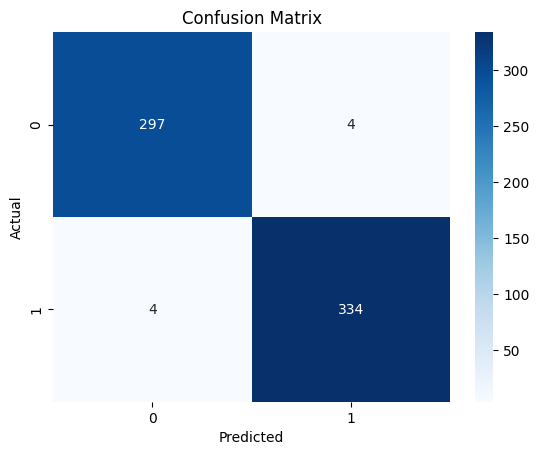

In [9]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
overlap = set(train_df['username']).intersection(set(test_df['username']))
print(f"🔍 Overlapping usernames: {len(overlap)}")


🔍 Overlapping usernames: 0


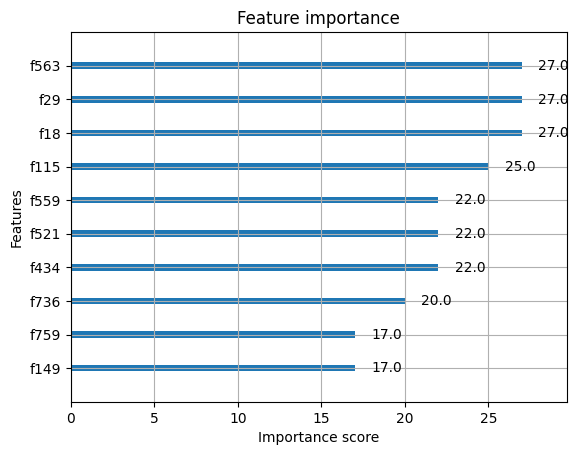

In [11]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.show()


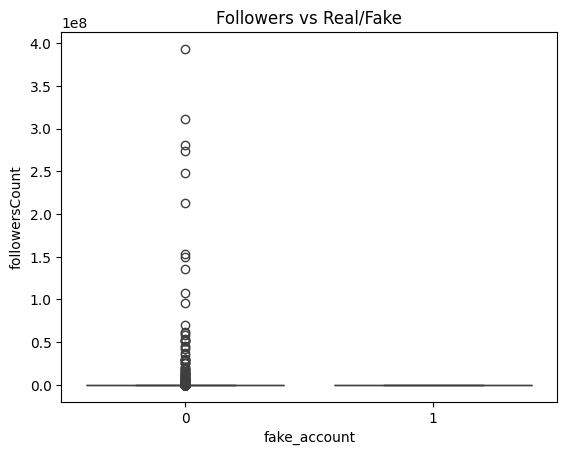

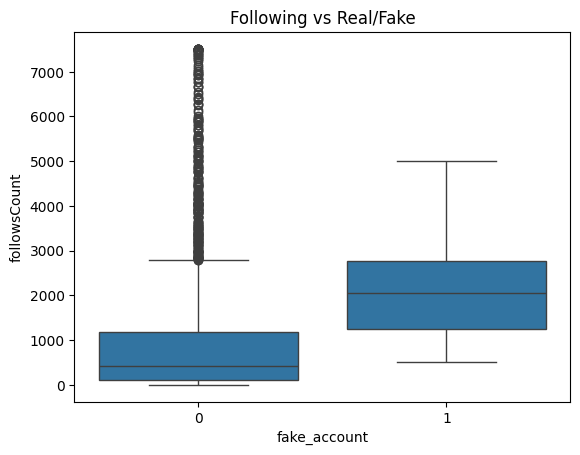

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='fake_account', y='followersCount', data=pd.concat([train_df, test_df]))
plt.title("Followers vs Real/Fake")
plt.show()

sns.boxplot(x='fake_account', y='followsCount', data=pd.concat([train_df, test_df]))
plt.title("Following vs Real/Fake")
plt.show()


In [13]:
test_df['prediction'] = y_pred
confused = test_df[test_df['prediction'] != test_df['fake_account']]
print(confused[['username', 'followersCount', 'followsCount', 'biography']])


              username  followersCount  followsCount  \
189   morrismichael643            36.0        4116.0   
253     momhustlempire        144246.0        1514.0   
281  taylormichelle603           173.0        1389.0   
331      blogger0668bt           122.0        1394.0   
350     iftekharshoshi             1.0         297.0   
364      erica_coffelt        869240.0         953.0   
447   thecocktailtimes          2683.0        2031.0   
619      monicacruz163           135.0        2269.0   

                                             biography  
189         Truth about vaccines they won't tell you 😱  
253  ꩜ Turn quotes into sales — faceless\r\n✿ For m...  
281         Truth about vaccines they won't tell you 😱  
331            Blogger | Passionate about music | ðŸ“š  
350                                 me ? simple person  
364  📧: ericacoffelt@yahoo.com\r\nMom | SLP | Dance...  
447  • Brand Ambassador @patron 🪄 \r\n• Ex - @w_goa...  
619                       Boost your re

In [14]:
print("Train Set:")
print(train_df['fake_account'].value_counts(normalize=True))
print("Test Set:")
print(test_df['fake_account'].value_counts(normalize=True))


Train Set:
fake_account
0    0.503898
1    0.496102
Name: proportion, dtype: float64
Test Set:
fake_account
1    0.528951
0    0.471049
Name: proportion, dtype: float64


In [15]:
!pip install emoji
import os
import emoji
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


Running on: cuda


In [16]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Fill NaNs for bio and username
train_df['biography'] = train_df['biography'].fillna('')
test_df['biography'] = test_df['biography'].fillna('')

train_df['username'] = train_df['username'].fillna('')
test_df['username'] = test_df['username'].fillna('')


In [17]:
def demojize_bio(text):
    return emoji.demojize(str(text), language='en')

train_df['biography_clean'] = train_df['biography'].apply(demojize_bio)
test_df['biography_clean'] = test_df['biography'].apply(demojize_bio)

train_df['text_combined'] = train_df['username'] + ' ' + train_df['biography_clean']
test_df['text_combined'] = test_df['username'] + ' ' + test_df['biography_clean']


In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.texts[idx]

class TextCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, batch):
        return self.tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=32)


In [20]:
def extract_text_features(texts):
    dataset = TextDataset(texts)
    loader = DataLoader(dataset, batch_size=32, collate_fn=TextCollator(tokenizer))
    features = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="🔠 BERT Embeddings"):
            batch = {k: v.to(device) for k, v in batch.items()}
            output = bert_model(**batch)
            features.append(output.pooler_output.cpu().numpy())
    return np.vstack(features)

text_features_train = extract_text_features(train_df['text_combined'].tolist())
text_features_test = extract_text_features(test_df['text_combined'].tolist())


🔠 BERT Embeddings: 100%|██████████| 20/20 [00:01<00:00, 12.35it/s]


In [21]:
# X for training, y is label
X_train = text_features_train
y_train = train_df['fake_account'].values

# X_test only (no y_test)
X_test = text_features_test


In [22]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict on test dataset (no label column)
predictions = model.predict(X_test)

# Attach predictions to test_df
test_df['predicted_fake_account'] = predictions

# View first 10 predictions
print(test_df[['username', 'biography', 'predicted_fake_account']].head(10))


                username                                          biography  \
0           designer26ar           ðŸ”¥ Student from Berlin | Traveler ðŸŒ   
1        traveling1363vj          ðŸ’° Engineer from Berlin | Traveler ðŸŒ   
2            12awara1243                                                      
3             chef7559yq    ðŸŒˆ Life of a Photographer in Bangalore | ðŸŽ¨   
4            blogger67tv  ðŸŽ¨ Posting about baking | Student from New York   
5              archdaily  The world’s most visited architecture platform...   
6    matthewwilkerson593           Natural cure for joint pain — click bio!   
7     kimberlywatkins934          Crypto profits daily — only ₹5000 needed!   
8  miladghaderi_official                                           ❤️الله❤️   
9             logan02502              Get rich with Shiba Inu — message me!   

   predicted_fake_account  
0                       1  
1                       1  
2                       0  
3                 

In [23]:
# === ✅ Cell to Replace ===

# 1. Use BERT features only (no fake_account as input)
X_train = text_features_train
y_train = train_df['fake_account'].values

X_test = text_features_test
y_test = test_df['fake_account'].values  # used only for evaluation

# 2. Train XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# 3. Predict on test set
y_pred = model.predict(X_test)

# 4. Compare predicted vs actual
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 5. Add prediction to DataFrame for viewing
test_df['predicted_fake_account'] = y_pred
print(test_df[['username', 'biography', 'fake_account', 'predicted_fake_account']].head(10))


✅ Accuracy: 0.9937402190923318

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       301
           1       1.00      0.99      0.99       338

    accuracy                           0.99       639
   macro avg       0.99      0.99      0.99       639
weighted avg       0.99      0.99      0.99       639


📉 Confusion Matrix:
 [[300   1]
 [  3 335]]
                username                                          biography  \
0           designer26ar           ðŸ”¥ Student from Berlin | Traveler ðŸŒ   
1        traveling1363vj          ðŸ’° Engineer from Berlin | Traveler ðŸŒ   
2            12awara1243                                                      
3             chef7559yq    ðŸŒˆ Life of a Photographer in Bangalore | ðŸŽ¨   
4            blogger67tv  ðŸŽ¨ Posting about baking | Student from New York   
5              archdaily  The world’s most visited architecture platform...   
6    matthewwilke

In [24]:
import pandas as pd

# Manually define 6 mixed examples (real & fake)
test_data = {
    'username': [
        'real_traveler12', 'getrichcrypto99', 'bakingwithlove_',
        'nft_invest_now', 'nature_clicks_07', 'daily_profit_bot'
    ],
    'followersCount': [340, 25, 150, 18, 320, 12],
    'followsCount':   [290, 1000, 180, 1300, 260, 2000],
    'verified':       [False, False, False, False, True, False],
    'biography': [
        "Sharing my travel journey across Europe 🌍✈️",
        "Earn ₹5000/day from home with crypto! 💸🚀",
        "Love baking cookies and sharing recipes 🍪❤️",
        "NFT profit guaranteed! DM now 🔥📈",
        "Nature photographer from Himachal Pradesh 🌲📸",
        "100% ROI in 48hrs — Limited spots! 💰🚨"
    ],
    'fullName': [
        "Emma Watson", "Crypto Queen", "Baker Girl",
        "NFT Dealer", "Nature Clicks", "ROI Expert"
    ],
    'postsCount': [42, 3, 67, 2, 104, 1],
    'profilePicUrl': [
        "https://example.com/pic1.jpg",
        "https://example.com/pic2.jpg",
        "https://example.com/pic3.jpg",
        "https://example.com/pic4.jpg",
        "https://example.com/pic5.jpg",
        "https://example.com/pic6.jpg"
    ],
    'joinedRecently': [False, True, False, True, False, True],
    'private':        [False, False, True, False, True, False],
    'fake_account':   [0, 1, 0, 1, 0, 1]  # ✅ Only used for final comparison
}

# Load into DataFrame
test_df_full = pd.DataFrame(test_data)

# Keep ground truth aside
true_labels = test_df_full['fake_account'].copy()

# Remove ground truth from model input
test_df = test_df_full.drop(columns=['fake_account'])


In [25]:
import emoji

def demojize_bio(text):
    return emoji.demojize(str(text), language='en')

test_df['biography_clean'] = test_df['biography'].apply(demojize_bio)
test_df['text_combined'] = test_df['username'] + ' ' + test_df['biography_clean']


In [26]:
# Assuming extract_text_features() function and BERT model are already loaded
text_features_test = extract_text_features(test_df['text_combined'].tolist())


🔠 BERT Embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


In [27]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training followers/follows
scaler = StandardScaler()
scaler.fit(train_df[['followersCount', 'followsCount']].fillna(0))


,copy,True
,with_mean,True
,with_std,True


In [28]:
# Make sure to use the same scaler you used during training
follow_features_test = test_df[['followersCount', 'followsCount']].fillna(0)
follow_features_test_scaled = scaler.transform(follow_features_test)


In [31]:
# ✅ Cell 5: Combine all features for testing (BERT + followers/follows)
# BERT gives 768-dim; followersCount + followsCount = 2-dim → total = 770-dim
X_test = np.hstack([text_features_test, follow_features_test_scaled])  # shape: (n, 770)


In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ Combine text and numeric features — same as used in training
X_test = np.hstack([text_features_test, follow_features_test_scaled])

# 🔍 Predict without revealing ground truth
y_pred = model.predict(X_test)

# ✅ Evaluate against the hidden ground truth
print("✅ Accuracy:", accuracy_score(true_labels, y_pred))
print("\n📄 Classification Report:\n", classification_report(true_labels, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(true_labels, y_pred))

# ✅ Add predictions for manual inspection
test_df['actual_fake_account'] = true_labels
test_df['predicted_fake_account'] = y_pred

print("\n🔍 Prediction Results:")
print(test_df[['username', 'biography', 'actual_fake_account', 'predicted_fake_account']])


NameError: name 'np' is not defined